In [2]:
import pandas as pd
import datetime
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

df_large = pd.read_csv(r"C:\Users\sahar\OneDrive\Desktop\SkyScanner2.csv")



def extract_week_number(week_of_year):
    try:
        return week_of_year.split('-W')[1]
    except IndexError:
        return None  



def prepare_data(df_large):
    columns_to_drop = ['mainCarrier', 'Market', 'UserCountryCode', 'OriginCountry', 'DestinationCountry', 'Year','Revenue','ODPax']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_large.columns]
    df_large_Clean = df_large.drop(columns=existing_columns_to_drop, errors='ignore')

    df_large_Clean['flightWeek'] = df_large_Clean['flightWeek'].apply(extract_week_number)
    df_large_Clean['weekOfYear'] = df_large_Clean['weekOfYear'].apply(extract_week_number)

    df_large_Clean['flightWeek'] = pd.to_numeric(df_large_Clean['flightWeek'], errors='coerce')
    df_large_Clean['weekOfYear'] = pd.to_numeric(df_large_Clean['weekOfYear'], errors='coerce')

    df_large_Clean['route'] = df_large_Clean['OriginAirport'] + '-' + df_large_Clean['DestinationAirport']
    df_large_Clean = df_large_Clean.drop(columns=['OriginAirport', 'DestinationAirport'])

    classes_order = ['ECONOMY', 'PREMIUMECONOMY', 'BUSINESS', 'FIRST']
    encoder = OrdinalEncoder(categories=[classes_order])
    df_large_Clean['cabinClass'] = encoder.fit_transform(df_large_Clean[['cabinClass']])

    le = LabelEncoder()
    df_large_Clean['kind'] = le.fit_transform(df_large_Clean['kind'])

    median_value = df_large_Clean['TripLengthNights'].median()
    df_large_Clean['TripLengthNights'].fillna(median_value, inplace=True)

    df_Case2 = df_large_Clean[df_large_Clean['isEWRoute'] != 0]
    df_Case2 = df_Case2.drop(columns=['isEWRoute'], errors='ignore')
    df_Case2 = df_Case2.groupby(['route', 'cabinClass', 'kind', 'flightWeek', 'weekOfYear', 'isConnectingFlight'], as_index=False).mean()

    return df_Case2





In [3]:

import pandas as pd
from pycaret.regression import *
import shap
import pycaret.classification


df_Case2_sortedBy_flightWeek = df_large.sort_values(by='flightWeek')


unique_weeks = df_Case2_sortedBy_flightWeek['flightWeek'].unique()

train_Index = unique_weeks[:round(len(unique_weeks) * 0.8)]
test_Index = unique_weeks[round(len(unique_weeks) * 0.8):]



df_train_raw = df_Case2_sortedBy_flightWeek[df_Case2_sortedBy_flightWeek['flightWeek'].isin(train_Index)]
df_test_raw = df_Case2_sortedBy_flightWeek[df_Case2_sortedBy_flightWeek['flightWeek'].isin(test_Index)]

df_train = prepare_data(df_train_raw)
df_test = prepare_data(df_test_raw)

features = ['cabinClass','kind','isConnectingFlight','TripLengthNights', 'TravelHorizonDays', 
            'Segments',  'TripPax'
            ,'flightWeek','weekOfYear','Average_FlightFare']
target = 'RedirectsCount'

reg_setup = setup(data=df_train[features + [target]], target=target,  session_id=42, log_experiment=False, 
                  log_plots=False,remove_multicollinearity=True,multicollinearity_threshold=0.95)


models_to_include = ['dt',  'lr',  'ridge','xgboost']

best_model = compare_models(include=models_to_include)
final_model = finalize_model(best_model)

predictions = predict_model(final_model, data=df_test[features + [target]])

predictions


,Description,Value
0,Session id,42
1,Target,RedirectsCount
2,Target type,Regression
3,Original data shape,"(136359, 11)"
4,Transformed data shape,"(136359, 11)"
5,Transformed train set shape,"(95451, 11)"
6,Transformed test set shape,"(40908, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.2926,0.2828,0.5316,0.5165,0.1585,0.1839,0.4110
lr,Linear Regression,0.3287,0.2943,0.5423,0.4965,0.1657,0.2150,0.0590
ridge,Ridge Regression,0.3287,0.2943,0.5423,0.4965,0.1657,0.2150,0.0650
dt,Decision Tree Regressor,0.3751,0.5479,0.7399,0.0624,0.2211,0.2292,1.5740


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3834,0.3494,0.5911,0.2150,0.2028,0.2947


,cabinClass,kind,isConnectingFlight,TripLengthNights,TravelHorizonDays,Segments,TripPax,flightWeek,weekOfYear,Average_FlightFare,RedirectsCount,prediction_label
0,0.0,1,1,7.0,310.0,2.0,2.0,12,19,103.934998,1.0,1.232531
1,0.0,1,0,7.0,329.0,1.0,1.0,13,18,220.649994,1.0,0.958410
2,0.0,1,1,7.0,350.0,1.0,1.0,17,19,367.459991,1.0,0.996913
3,0.0,1,0,7.0,307.0,4.0,4.0,12,20,97.992500,1.0,1.653566
4,0.0,1,0,7.0,315.0,4.0,4.0,13,20,57.639999,2.0,1.689483
...,...,...,...,...,...,...,...,...,...,...,...,...
2036,0.0,2,0,3.0,356.0,2.0,1.0,18,19,80.220001,1.0,1.401278
2037,0.0,2,0,3.0,352.0,4.0,2.0,18,20,330.982513,2.0,1.412174
2038,2.0,2,0,13.0,347.0,4.0,2.0,17,20,372.772491,1.0,1.004725
2039,0.0,2,1,14.0,336.0,2.0,1.0,14,18,113.254997,1.0,1.024999


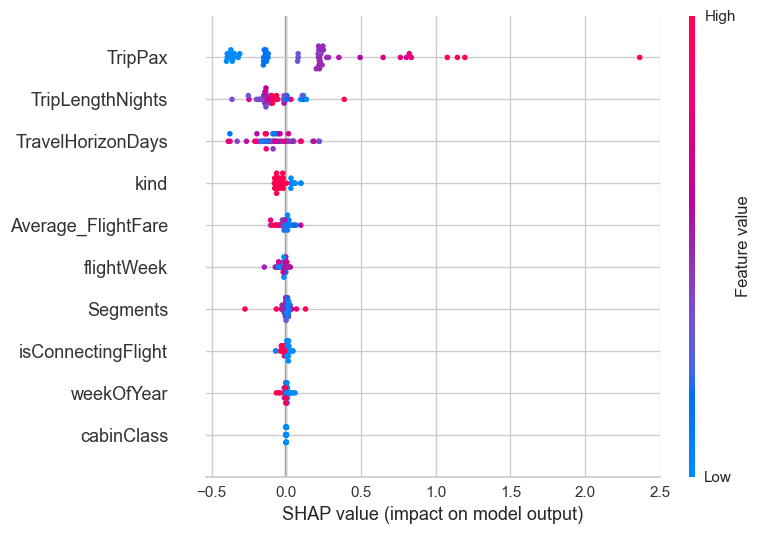

In [7]:
import shap
import matplotlib.pyplot as plt
import xgboost
df_test_sample = df_test.sample(n=min(50, len(df_test)), random_state=42)

if hasattr(final_model, 'steps'):
    model = final_model.steps[-1][1]
else:
    model = final_model

if isinstance(model, (xgboost.XGBRegressor, xgboost.XGBClassifier)):
    explainer = shap.TreeExplainer(model)
else:
    explainer = shap.KernelExplainer(model.predict, df_train[features].iloc[:100, :])  

shap_values = explainer.shap_values(df_test_sample[features])  

shap.summary_plot(shap_values, df_test_sample[features])

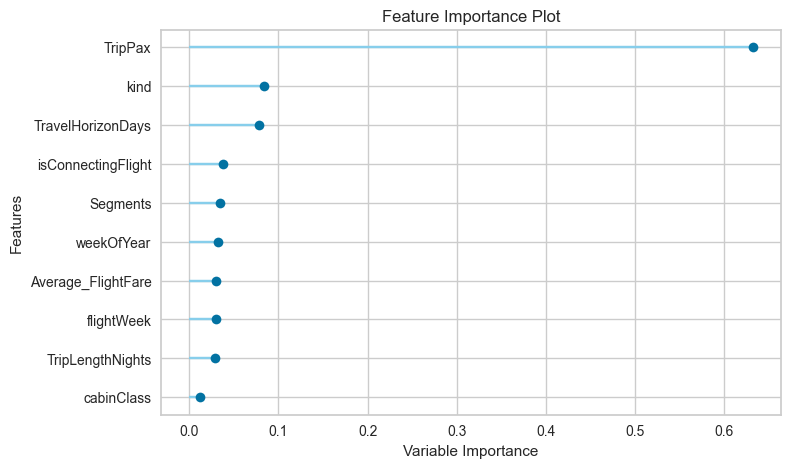

In [5]:
plot_model(final_model, plot='feature')


In [6]:
import plotly.express as px
import pandas as pd

shap_df = pd.DataFrame(shap_values, columns=df_test_sample[features].columns)
shap_df = shap_df.abs().mean(axis=0).reset_index()
shap_df.columns = ['feature', 'impact']
shap_df = shap_df.sort_values(by='impact', ascending=False)

print(shap_df)

fig = px.scatter(
    shap_df,
    x='impact',
    y='feature',
    color='feature',
    title='SHAP Values Impact on Model Output',
    labels={'impact': 'SHAP value (impact on model output)', 'feature': 'Features'}
)

fig.update_layout(yaxis={'categoryorder': 'total ascending'})

fig.show()


              feature    impact
6             TripPax  0.394000
3    TripLengthNights  0.126627
4   TravelHorizonDays  0.126142
1                kind  0.051469
9  Average_FlightFare  0.029412
7          flightWeek  0.022588
5            Segments  0.021355
2  isConnectingFlight  0.018617
8          weekOfYear  0.011211
0          cabinClass  0.001842
